# Домашнее задание №4
*Задание выполнил* **Чащин Артем Максимович**

*Курс:* **3**, *группа:* **МФТИ-1**

**[GitHub](https://github.com/alexvilno/PSU_TIMESERIES/tree/HW2)**

**[Telegram](https://t.me/artemchashchin)**

## Оглавление
* [Импорт данных](#import)
* [Описание всех функций, которые мне нужны](#func)
    * [split_dataframe](#split_dataframe)
    * [get_arima_pred_list](#get_arima_pred_list)
    * [view_forecast_plot_with_pred](#view_forecast_plot_with_pred)
    * [print_metrics](#print_metrics)
* [Предсказание с помощью ARMA и ARIMA](#arma)
* [Оценка метрик](#benchmark)
* [Делаем пропуски](#misses)
* [Убираем пропуски](#rmisses)
* [Ищем выбросы](#dec)
* [Убираем выбросы](#rdec)



### Импорт <a id="import"></a>

In [245]:
import os
import pandas as pd
import numpy as np

from os import path
from matplotlib import pyplot as plt
from dotenv import load_dotenv

In [246]:
load_dotenv(dotenv_path='../.env')

True

Импортируем данныe

In [247]:
file_path = os.getenv('PATH_TO_DATA')

sales_df = pd.read_csv(path.join(os.sep, file_path, 'data.csv'), names=["t","x"], skiprows=1)

Функция, которая добавляет легенду на график

In [248]:
def plot_assignation(axp, data, xlabel, ylabel, title1, periods):
    axp.plot(data)
    axp.set_xlabel(xlabel)
    axp.set_ylabel(ylabel)
    axp.set_title(title1)
    axp.set_xticks(np.arange(0, len(sales_df['x']) + 1, 12))
    axp.set_xticklabels(np.arange(periods + 1))

В соответсвтии с моими данными я визуализирую выборку на графике и добавляю его легенду

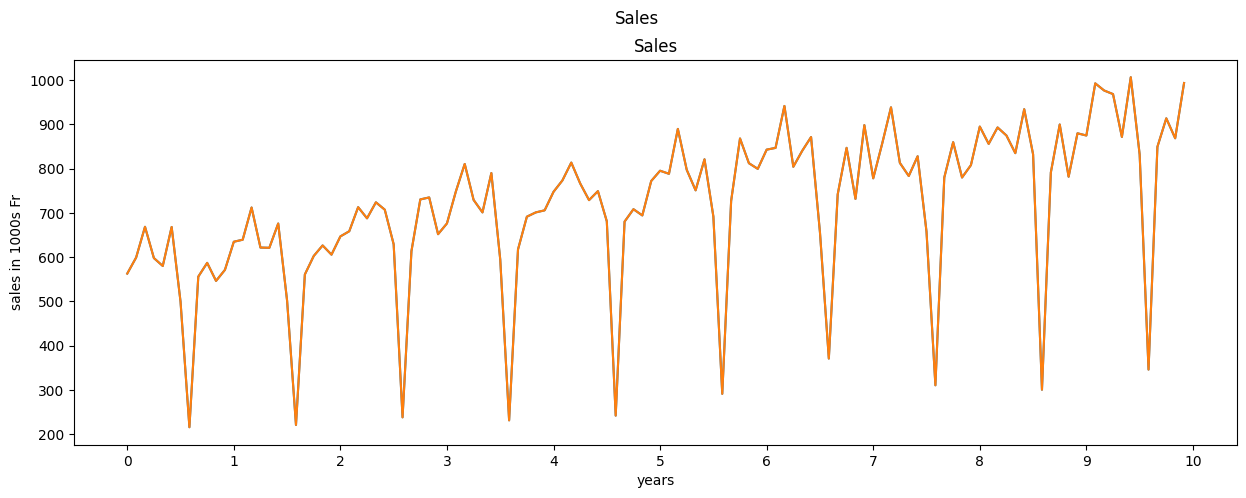

In [249]:
#выборка по 10 годам
period = 10

fig, axs = plt.subplots(1,1,figsize=(15,5))
fig.suptitle('Sales')
plot_assignation(axs, sales_df["x"], "years","sales in 1000s Fr","Sales", period)
axs.plot(sales_df['x'])

### Описание всех функций, которые мне нужны <a id="func"></a>

#### split_dataframe <a id="split_dataframe"> </a>

Эта функция разбивает датафрейм на необходимое число датафреймов по заданным процентным соотношениям каждого разбиения *(ratios)*.
Т.е. например если нам нужно разбить датафрейм на три части в процентном соотношении *30%, 25%, 45%*, то нужно передать в ratios=[0.3, 0.25, 0.45] а в num_partitions=3 *(len(ratios) должна быть равна num_partitions, сумма ratios должна быть равна 1)*

In [250]:
from typing import Optional

def split_dataframe(
    df: pd.DataFrame, 
    num_partitions: int,
    ratios: list[float],
    time_index: str
) -> Optional[list[pd.DataFrame]]:
    """
    num_partitions - количество разбиений, на который необходимо разбить датафрейм
    ratios - позиционный список процентных соотношений разбиений, значения - часть от общего количества наблюдений в датафрейме
    """

    if len(ratios) != num_partitions:
        raise ValueError("Количество разбиений должно совпадать c количеством ratios")
    if sum(ratios) != 1 and ratios:
        raise ValueError("Сумма ratios не равна 1")
    
    partitions = []
    cutoffs = [int(round(len(df) * ratio, 0)) for ratio in ratios]

    for i in range(num_partitions):
        if i == 0:
            lower_bound = 0
        else:
            lower_bound = sum(cutoffs[:i])

        upper_bound = sum(cutoffs[:i + 1])

        partition = df[(df[time_index] > lower_bound) & (df[time_index] <= upper_bound)]
        partitions.append(partition)

    return partitions

#### get_arima_pred_list <a id="get_arima_pred_list"> </a>

Функция используется для получения списка предсказаний, сделанных с помощью модели **ARIMA**. Длина возвращаемого списка равна длине test.

In [251]:
from typing import Union, List

def get_arima_pred_list(
    p: Union[List[int], int], 
    d: int, 
    q: Union[List[int], int],
    train: pd.DataFrame,
    test: pd.DataFrame,
    data_index: str
) -> list:
    """
    p - число наблюдений лагов в модели
    d - степень дифференцируемости
    q - скользящее среднее
    train - обучающая выборка
    test - тестовая выборка
    target_index - индекс target столбца в датафрейме
    """
    history = [x for x in train[data_index]]

    arma_pred = list()

    for t in range(len(train + 1),len(test) + len(train)):
        model = ARIMA(history, order=(p,d,q))
        model_fit = model.fit()
        out = model_fit.forecast()
        yhat = out[0]
        obs = test[data_index][t]
        arma_pred.append(yhat)
        history.append(obs)

    return arma_pred

#### view_forecast_plot_with_pred <a id="view_forecast_plot_with_pred"> </a>

Функция отрисовывает график датафреймов, а также поверх этих датафреймов может отрисовать предсказания, если они переданы в функцию. Важно соблюдать позиционность передачи аргументов, т.е. если передать 

```dataframes=[df, df1, df2], predicted_data=[None, df1_pred ,None]``` 

то поверх df1 будет отрисовываться df1_pred при условии, что количество наблюдений одинаково. 

In [252]:
from typing import List, Optional

def view_forecast_plot_with_pred(dataframes: List[pd.DataFrame], predicted_dataframes: Optional[List[pd.DataFrame]] = None) -> None:
    plt.figure(figsize=(15,5))

    for i, df in enumerate(dataframes):
        plt.plot(df.t, df.x, label=f'Partition {i+1}')

    for i, df in enumerate(predicted_dataframes):
        if df is not None:
            if len(dataframes[i]) != len(df):
                raise ValueError(f"Размерность датафрейма {i} не совпадает с размерностью его предсказаний")
            plt.plot(dataframes[i].t, df, label=f'Partition {i+1} predicted')

    plt.plot()
    plt.legend()
    plt.show()

#### print_metrics <a id="print_metrics"> </a>

Функция считает метрики *RMSE, MAPE, SMAPE, MAE, R2*

In [253]:
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error, mean_squared_error, r2_score

def SMAPE(forecast: pd.DataFrame, forecast_pred: pd.DataFrame) -> float:
    return np.sum((np.abs(forecast - forecast_pred)) / ((np.abs(forecast) + np.abs(forecast_pred)) / 2)) * 100 / len(forecast)

def print_metrics(true: pd.DataFrame, pred: list, target_index: str):
    print("RMSE:", np.sqrt(mean_squared_error(true[target_index], pred)))
    print("MAPE:", mean_absolute_percentage_error(true[target_index], pred))
    print("SMAPE:", SMAPE(true[target_index], pred))
    print("MAE:", mean_absolute_error(true[target_index], pred))
    print("R2: ", r2_score(true[target_index], pred))

### Предсказание с помощью ARMA и ARIMA <a id="arma"></a>

/Users/alexvilno/Desktop/TIMESERIES/GIT_HOMEWORK/PSU_TIMESERIES/venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/alexvilno/Desktop/TIMESERIES/GIT_HOMEWORK/PSU_TIMESERIES/venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/alexvilno/Desktop/TIMESERIES/GIT_HOMEWORK/PSU_TIMESERIES/venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


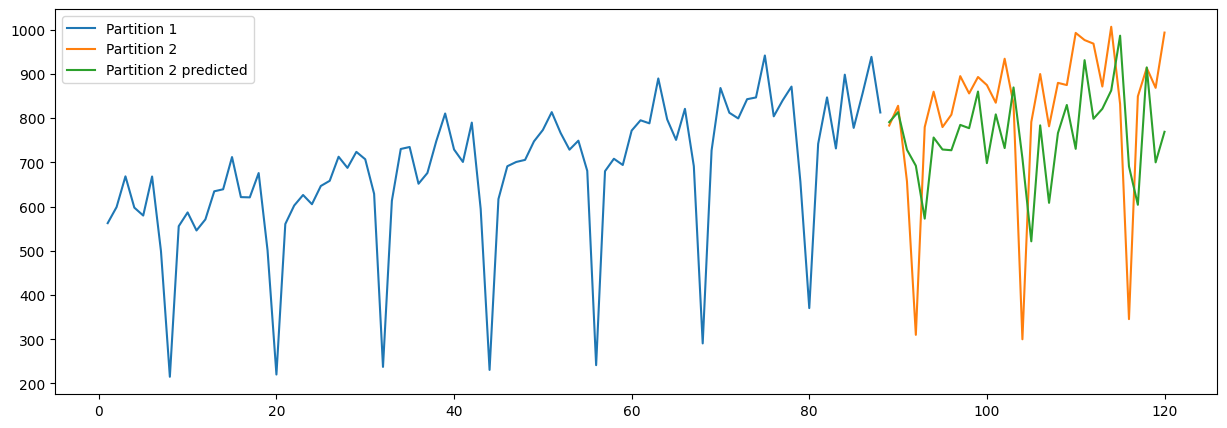

RMSE: 177.8290001820007
MAPE: 0.2339134266647111
SMAPE: 20.34280918423145
MAE: 141.26196406774648
R2:  -0.023933416191394663


In [254]:
train, test = split_dataframe(sales_df, 2, [0.73, 0.27], 't')
arma_pred = get_arima_pred_list(5, 0, 2, train, test, 'x')
view_forecast_plot_with_pred([train, test],[None, arma_pred])
print_metrics(test, arma_pred, 'x')

/Users/alexvilno/Desktop/TIMESERIES/GIT_HOMEWORK/PSU_TIMESERIES/venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


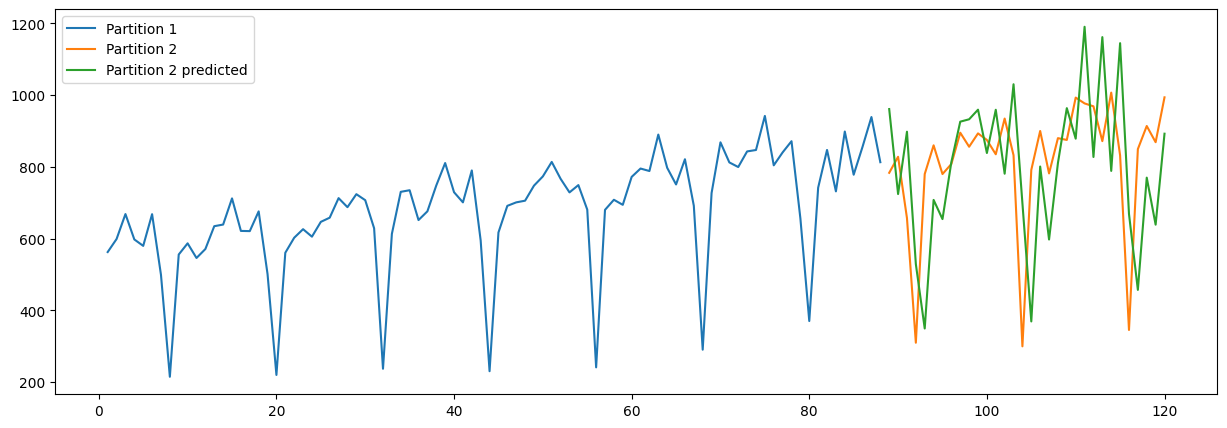

In [255]:
train, test = split_dataframe(sales_df, 2, [0.73, 0.27], 't')
arima_pred = get_arima_pred_list(5, 3, 2, train, test, 'x')
view_forecast_plot_with_pred([train, test],[None, arima_pred])

### Оценка метрик <a id="benchmark"> </a>

In [256]:
print("Оценка метрик для ARMA")
print_metrics(test, arma_pred, 'x')
print("Оценка метрик для ARIMA")
print_metrics(test, arima_pred, 'x')

Оценка метрик для ARMA
RMSE: 177.8290001820007
MAPE: 0.2339134266647111
SMAPE: 20.34280918423145
MAE: 141.26196406774648
R2:  -0.023933416191394663
Оценка метрик для ARIMA
RMSE: 216.9619224117806
MAPE: 0.2757420278634542
SMAPE: 25.931050686001367
MAE: 183.78998436205194
R2:  -0.5241706121003147
